In [1]:
from os import listdir, makedirs
from os.path import isfile, isdir, join
from ultralytics import YOLO
import fitz
import cv2
import numpy as np
import math
import shutil
import secrets
import random
import cvzone
from ultralytics.utils.plotting import Annotator
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image, ImageFilter, ImageOps
import matplotlib.pyplot as plt

path_to_pdf = "PDFs"
path_to_imgs = "Images"
path_to_noise_reduct_imgs = "NoiseReduct"
path_to_deskew_imgs = "Deskews"
path_to_stamp_removed_imgs = "NoStamp"

path_to_labels="StampDetectLabels"
path_to_dataset="StampDetectDatsSet"

path_to_dataset2="Dataset2"

path_to_dataset3_circle="StampRemoveDatasetCircle"
path_to_dataset3_square="StampRemoveDatasetSquare"
pdf_files_name = [f for f in listdir(path_to_pdf) if isfile(join(path_to_pdf, f))]

In [2]:
def ConvertPDFToJPG(output_path, input_path, files_name):
    if not isdir(output_path):
        makedirs(output_path)
    index = 0
    for file_name in files_name:
        doc = fitz.open(join(input_path, file_name))
        for i in range(len(doc)):
            page = doc[i]
            pix = page.get_pixmap(dpi=200)
            pix.save(f"{output_path}/{index}.jpg")
            index += 1
ConvertPDFToJPG(path_to_imgs, path_to_pdf, pdf_files_name)

In [4]:
def DenoiseAndFixedSize(output_path, input_path, kernel_size = 3):
    if not isdir(output_path):
        makedirs(output_path)
    imgs_name = [f for f in listdir(input_path) if isfile(join(input_path, f))]
    for img_name in imgs_name:
        path_to_img = join(input_path, img_name)
        img = cv2.imread(path_to_img)
        img = cv2.resize(img, (1700, 2400))
        img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
        cv2.imwrite(join(output_path, img_name), img)
DenoiseAndFixedSize(path_to_noise_reduct_imgs, path_to_imgs)

In [5]:
def CorrectSkew(output_path, input_path, step=0.1, limit=5):
    def DetermineScore(image, angle):
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h))
        # Projection function P
        histogram = np.sum(image, axis=1, dtype=float)
        # Postl's alignment function phi
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score
    if not isdir(output_path):
        makedirs(output_path)
    imgs_name = [f for f in listdir(input_path) if isfile(join(input_path, f))]
    angles = np.arange(-limit, limit + step, step)
    angles = [round(angle, 1) for angle in angles]
    for img_name in imgs_name:
        scores = []
        path_to_img = join(input_path, img_name)
        img = cv2.imread(path_to_img)
        img_bin = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, img_bin = cv2.threshold(img_bin, 127, 255, cv2.THRESH_BINARY)
        # Calculate score of image from angle -limit to limit + step
        for angle in angles:
            histogram, score = DetermineScore(img_bin, angle)
            scores.append(score)
        best_angle = angles[scores.index(max(scores))]
        # Postl’s fiducial reduction (FP) (rotate image)
        (h, w) = img.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
        corrected = cv2.warpAffine(img, M, (w, h))
        cv2.imwrite(join(output_path, img_name), corrected)
        print(img_name, best_angle)
CorrectSkew(path_to_deskew_imgs, path_to_noise_reduct_imgs)

0.jpg -0.5
1.jpg -0.7
2.jpg -0.8
3.jpg 0.1
4.jpg 0.1
5.jpg -0.0
6.jpg -0.0
7.jpg -0.0
8.jpg -0.0
9.jpg -0.0
10.jpg -0.0
11.jpg -0.0
12.jpg -0.0
13.jpg -0.0
14.jpg -0.0
15.jpg -0.0
16.jpg -0.0
17.jpg -0.0
18.jpg -0.0
19.jpg -0.0
20.jpg -0.0
21.jpg -0.0
22.jpg -0.0
23.jpg -0.0
24.jpg -0.0
25.jpg -0.0
26.jpg -0.1
27.jpg -0.0
28.jpg 0.2
29.jpg -0.3
30.jpg 0.1
31.jpg -0.5
32.jpg -0.3
33.jpg -0.4
34.jpg -0.3
35.jpg -0.3
36.jpg -0.1
37.jpg -0.4
38.jpg 0.2
39.jpg 0.1
40.jpg -0.0
41.jpg 0.2
42.jpg -0.0
43.jpg 0.1
44.jpg 0.1
45.jpg 0.1
46.jpg -0.0
47.jpg 0.1
48.jpg 0.2
49.jpg 0.2
50.jpg 0.1
51.jpg 0.1
52.jpg -0.0
53.jpg 0.2
54.jpg -0.0
55.jpg 0.1
56.jpg -0.0
57.jpg -0.0
58.jpg -0.0
59.jpg -0.0
60.jpg 0.1
61.jpg -0.1
62.jpg 0.1
63.jpg 0.2
64.jpg 0.3
65.jpg 0.4
66.jpg 0.4
67.jpg -0.4
68.jpg 0.2
69.jpg -0.3
70.jpg 0.1
71.jpg -0.5
72.jpg 0.1
73.jpg -0.5
74.jpg -0.1
75.jpg -0.7
76.jpg -0.1
77.jpg -0.6
78.jpg -0.2
79.jpg -0.5
80.jpg -0.0
81.jpg -0.5
82.jpg -0.0
83.jpg -0.1
84.jpg -0.1
85.jpg -0.1
86.j

In [3]:
def CreateDataset(target_path, label_path, source_path):
    if isdir(target_path):
        shutil.rmtree(target_path)

    train = join(target_path, "train")
    valid = join(target_path, "valid")
    train_imgs = join(train, "images")
    train_labels = join(train, "labels")
    valid_imgs = join(valid, "images")
    valid_labels = join(valid, "labels")
    makedirs(train_imgs)
    makedirs(train_labels)
    makedirs(valid_imgs)
    makedirs(valid_labels)

    labels = [f for f in listdir(label_path) if isfile(join(label_path, f))]
    imgs = [(f.split(".")[0]+".jpg") for f in labels]
    print("Total data files", len(imgs))
    train_num = int(input("How much files you want to use as train:"))
    for i, _ in enumerate(labels):
        if i + 1 < train_num:
            shutil.copyfile(join(label_path, labels[i]), join(train_labels, labels[i]))
            shutil.copyfile(join(source_path, imgs[i]), join(train_imgs, imgs[i]))
        else:
            shutil.copyfile(join(label_path, labels[i]), join(valid_labels, labels[i]))
            shutil.copyfile(join(source_path, imgs[i]), join(valid_imgs, imgs[i]))
CreateDataset(path_to_dataset, path_to_labels, path_to_deskew_imgs)

Total data files 304


In [ ]:
# trainning
model = YOLO("yolov9c.pt")
model.info()
model.train(data="data.yaml", epochs=20, imgsz=640, device="cpu")

In [ ]:
# model = YOLO("best.pt")
# result = model("test.jpg")
# img = cv2.imread("test.jpg")
# for r in result:
#     annotator = Annotator(img)
#     boxes = r.boxes
#     for box in boxes:
#         b = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format
#         c = box.cls
#         annotator.box_label(b, model.names[int(c)])
        
# img = annotator.result()  
# cv2.imwrite("result.jpg", img)

In [5]:
def CreateStampDataSet(target_path_circle, target_path_square, train_nums, valid_nums, source_path):
    docs_path=join(source_path, "DocsOnly")
    def Create(target_path, docs, stamps, nums, stamps_path):
        if not isdir(target_path):
            makedirs(target_path)
        imgs = join(target_path, "images")
        if not isdir(imgs):
            makedirs(imgs)
        labels = join(target_path, "labels")
        if not isdir(labels):
            makedirs(labels)
        for i in range(nums):
            # read random doc gray scale
            random_doc = cv2.imread(join(docs_path, secrets.choice(docs)))
            random_doc_og = random_doc.copy()
            x1, y1 = random_doc.shape[:2]
            # read random stamp gray scale
            random_stamp = cv2.imread(join(stamps_path, secrets.choice(stamps)), cv2.IMREAD_UNCHANGED)
            random_stamp = cv2.blur(random_stamp, (3,3))
            x2, y2 = random_stamp.shape[:2]
            # choose random coordinate so stamp is within doc
            x = secrets.randbelow(abs(x1-x2))
            y = secrets.randbelow(abs(y1-y2))
            w = x1 if x+x2 > x1 else x+x2
            h = y1 if y+y2 > y1 else y+y2
            # random rotate
            random_number = random.uniform(-5.0, 5.0)
            M = cv2.getRotationMatrix2D((y2/2, x2/2), random_number, 1.0)
            random_stamp = cv2.warpAffine(random_stamp, M, (y2, x2))
            # random flip
            if bool(random.getrandbits(1)):
                random_stamp = cv2.flip(random_stamp, 0)
            if bool(random.getrandbits(1)):
                random_stamp = cv2.flip(random_stamp, 1)
            # overlay
            random_doc = cvzone.overlayPNG(random_doc, random_stamp, (y, x))
            # write image gray scale
            random_doc = cv2.cvtColor(random_doc, cv2.COLOR_BGR2GRAY)
            random_doc_og = cv2.cvtColor(random_doc_og, cv2.COLOR_BGR2GRAY)
            name = "{}.jpg".format(i)
            cv2.imwrite(join(imgs, name), random_doc[x:w, y:h])
            cv2.imwrite(join(labels, name), random_doc_og[x:w, y:h])
    # create dataset path
    if not isdir(target_path_circle):
        makedirs(target_path_circle)
    if not isdir(target_path_square):
        makedirs(target_path_square)
    # path to source
    docs_path = join(source_path, "DocsOnly")
    circle_path = join(source_path, "CirclesOnly")
    square_path = join(source_path, "SquaresOnly")
    # source file name
    docs = [f for f in listdir(docs_path) if isfile(join(docs_path, f))]
    circle_stamps = [f for f in listdir(circle_path) if isfile(join(circle_path, f))]
    square_stamps = [f for f in listdir(square_path) if isfile(join(square_path, f))]
    # create train
    Create(join(target_path_circle, "train"), docs, circle_stamps, train_nums, join(source_path, "CirclesOnly"))
    Create(join(target_path_square, "train"), docs, square_stamps, train_nums, join(source_path, "SquaresOnly"))
    # create valid
    Create(join(target_path_circle, "valid"), docs, circle_stamps, valid_nums, join(source_path, "CirclesOnly"))
    Create(join(target_path_square, "valid"), docs, square_stamps, valid_nums, join(source_path, "SquaresOnly"))
CreateStampDataSet(path_to_dataset3_circle, path_to_dataset3_square, 1024, 96, path_to_dataset2)

In [3]:
class CustomDataLoader(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.imgs_path = join(self.root_dir, "images")
        self.labels_path = join(self.root_dir, "labels")
        self.imgs_name = [f for f in listdir(self.imgs_path) if isfile(join(self.imgs_path, f))]
    def __len__(self):
        return len(self.imgs_name)
    def __getitem__(self, index):
        img = Image.open(join(self.imgs_path, self.imgs_name[index])).resize((224,224)).convert("L")
        label = Image.open(join(self.labels_path, self.imgs_name[index])).resize((224,224)).convert("L")
        if self.transform:
            img = self.transform(img)
            label = self.transform(label)
        return img, label

train_data_circle = CustomDataLoader(join(path_to_dataset3_circle, "train"), transform=torchvision.transforms.ToTensor())
train_loader_circle = DataLoader(dataset=train_data_circle, batch_size=32, shuffle=True)
valid_data_circle = CustomDataLoader(join(path_to_dataset3_circle, "valid"), transform=torchvision.transforms.ToTensor())
valid_loader_circle = DataLoader(dataset=valid_data_circle, batch_size=32, shuffle=True)

train_data_square = CustomDataLoader(join(path_to_dataset3_square, "train"), transform=torchvision.transforms.ToTensor())
train_loader_square = DataLoader(dataset=train_data_square, batch_size=32, shuffle=True)
valid_data_square = CustomDataLoader(join(path_to_dataset3_square, "valid"), transform=torchvision.transforms.ToTensor())
valid_loader_square = DataLoader(dataset=valid_data_square, batch_size=32, shuffle=True)


FileNotFoundError: [Errno 2] No such file or directory: 'StampRemoveDatasetCircle/train/images'

In [3]:
class HN(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 1):
        super(HN, self).__init__()
        self.kernel_size = 3
        self.stride = 1
        self.stride_transpose = 2
        self.padding = 1
        self.maxpool = 2
        # block 1 is layer 1
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=48, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=self.maxpool)
        )
        # block 2 is for layer 2..5
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=self.maxpool)
        )
        # block 3 is layer 6, 7
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.ReLU(inplace=True),
            # upsample with scale factor of 2
            nn.ConvTranspose2d(in_channels=48, out_channels=48, kernel_size=self.kernel_size, stride=self.stride_transpose, padding=self.padding, output_padding=self.padding)
        )
        # block 4 is layer 8, 9
        # concat 1 = torch.cat(layer4, layer7)
        # dim concat 1 = (?, ?, 96)
        self.block4 = nn.Sequential(
            # layer 8 = Conv+ReLU(concat 1)
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.ReLU(inplace=True),
            # layer 9 = Conv+Rely(layer 8)
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=96, out_channels=96, kernel_size=self.kernel_size, stride=self.stride_transpose, padding=self.padding, output_padding=self.padding)
        )
        # block 5 is for (10, 11), (12, 13), (14, 15)
        # concat 2 = torch.cat(layer3, layer 9)
        # dim concat 2 = (?, ?, 144)
        self.block5 = nn.Sequential(
            # layer 10 = Conv+ReLU(concat)
            nn.Conv2d(in_channels=144, out_channels=96, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.ReLU(inplace=True),
            # layer 11 = Conv+ReLU(layer 10)
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=96, out_channels=96, kernel_size=self.kernel_size, stride=self.stride_transpose, padding=self.padding, output_padding=self.padding)
        )
        # block 6 is layer 16..18
        self.block6 = nn.Sequential(
            # concat_5 = torch.cat(x, layer 14)
            # dim concat 5 = (?, ?, in_chanel + 96)
            nn.Conv2d(in_channels=in_channels+96, out_channels=64, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.LeakyReLU(0.1, inplace=True)
        )
    def forward(self, x):
        # Encoder
        pool1 = self.block1(x)
        pool2 = self.block2(pool1)
        pool3 = self.block2(pool2)
        pool4 = self.block2(pool3)
        pool5 = self.block2(pool4)

        # Decoder
        upsample1 = self.block3(pool5)

        concat1 = torch.cat((upsample1, pool4), dim=1)
        upsample2 = self.block4(concat1)

        concat2 = torch.cat((upsample2, pool3), dim=1)
        upsample3 = self.block5(concat2)

        concat3 = torch.cat((upsample3, pool2), dim=1)
        upsample4 = self.block5(concat3)

        concat4 = torch.cat((upsample4, pool1), dim=1)
        upsample5 = self.block5(concat4)

        concat_5 = torch.cat((upsample5, x), dim=1)
        output = self.block6(concat_5)
        return torch.clamp(output, min=None, max=255)
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool(x)

        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.pool(x)
        
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.pool(x)

        return x
PN = VGG16()
# torch.save(PN, "pn.pt")
model2 = HN()
criteriation = nn.MSELoss(reduction='sum')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [ ]:
# model2 = torch.load("model2_square_.pt")
PN = torch.load("pn.pt")
PN.to(device)
model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)
for epoch in range(500):
    losses = []
    for i, (data, label) in enumerate(train_loader_square):
        data = data.to(device=device)
        label = label.to(device=device)
        scores = model2(data)
        # no perception network not enough vram
        # pn_data = PN(data)
        # pn_label = PN(label)

        # loss = criteriation(pn_data, pn_label)
        loss += criteriation(scores, label)
        
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Cost at epoch {epoch} {i} is {sum(losses)/len(losses)}')
torch.save(model2, "model2_square_500.pt")

valid loss min at i =  594.0


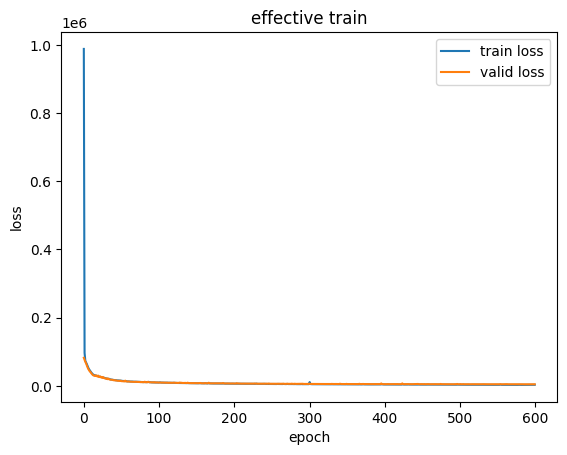

In [39]:
f = open("circle_train_log.txt", "r")
lines = f.readlines()
y_train = []
y_valid = []
x = []

min = 100000000000000000000000000000
min_index = -1
i = 0
while i < len(lines)-1:
    x.append(i/2)
    train = lines[i].split()
    y_train.append(float(train[len(train)-1]))
    valid = lines[i+1].split()
    y_valid.append(float(valid[len(valid)-1]))
    if float(valid[len(valid)-1]) < min:
        min = float(valid[len(valid)-1])
        min_index = i / 2 + 1
    i += 2

print("valid loss min at i = ", min_index + 1)
plt.plot(x, y_train, label="train loss")  # Plot first line with label
plt.plot(x, y_valid, label="valid loss")  # Plot second line with label

# Add labels and title
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("effective train")

# Add legend to differentiate lines
plt.legend()

# Show the plot
plt.show()

In [4]:
model2_trained = torch.load("model2_train_results/model2_square_max255/model2_square_450.pt")
model2_trained.to(device)
# for i, (data, label) in enumerate(valid_loader_circle):
#     data = data.to(device=device)
#     label = label.to(device=device)
#     scores = model2_trained(data)
#     loss = criteriation(scores, label)
#     print(loss)

HN(
  (block1): Sequential(
    (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (block4): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=Tr

In [6]:
img = Image.open("circle4.jpg").resize((224,224)).convert("L")
transforms = torchvision.transforms.ToTensor()
img = transforms(img)
img = torch.unsqueeze(img, 0)

result = model2_trained(img)
result = torch.squeeze(result, 0)

toImg = torchvision.transforms.ToPILImage()
img = toImg(result)

img.show()

In [27]:
model = YOLO("best.pt")
model2_trained_circle = torch.load("model2_train_results/model2_circle_max255/model2_circle_450.pt")
model2_trained_circle.to(device)
model2_trained_square = torch.load("model2_train_results/model2_square_max255/model2_square_580.pt")
model2_trained_square.to(device)

transforms = torchvision.transforms.ToTensor()
toImg = torchvision.transforms.ToPILImage()

def RemoveStampFromImage(path_to_img):
    result = model(path_to_img)
    img = Image.open(path_to_img)
    for r in result:
        annotator = Annotator(img)
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            # read and convert image to tensor
            stamp_img = img.crop((x1, y1, x2, y2)).resize((224,224)).convert("L")
            stamp_img = transforms(stamp_img)
            stamp_img = torch.unsqueeze(stamp_img, 0)

            # selecct correct model
            c = box.cls
            match model.names[int(c)]:
                case "circle_stamp":
                    stamp_img = model2_trained_circle(stamp_img)
                case "square_stamp":
                    stamp_img = model2_trained_square(stamp_img)

            stamp_img = torch.squeeze(stamp_img, 0)
            stamp_img = toImg(stamp_img)
            stamp_img = stamp_img.resize((x2-x1, y2-y1))
            img.paste(stamp_img, (x1, y1), stamp_img)
    return img
def RemoveStamp(output_path, input_path):
    if not isdir(output_path):
        makedirs(output_path)
    imgs_name = [f for f in listdir(input_path) if isfile(join(input_path, f))]
    for img_name in imgs_name:
        path_to_img = join(input_path, img_name)
        img = RemoveStampFromImage(path_to_img)
        img.save(join(output_path, img_name))
RemoveStamp(path_to_stamp_removed_imgs, path_to_deskew_imgs)


image 1/1 /home/admin/Documents/Work/Git/ste-intern-ocr-project/Deskews/0.jpg: 640x480 2 square_stamps, 282.2ms
Speed: 3.5ms preprocess, 282.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/admin/Documents/Work/Git/ste-intern-ocr-project/Deskews/1.jpg: 640x480 1 circle_stamp, 279.6ms
Speed: 4.0ms preprocess, 279.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/admin/Documents/Work/Git/ste-intern-ocr-project/Deskews/10.jpg: 640x480 (no detections), 278.7ms
Speed: 3.6ms preprocess, 278.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/admin/Documents/Work/Git/ste-intern-ocr-project/Deskews/100.jpg: 640x480 (no detections), 280.4ms
Speed: 4.0ms preprocess, 280.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/admin/Documents/Work/Git/ste-intern-ocr-project/Deskews/1000.jpg: 640x480 (no detections), 281.1ms
Speed: 3.9ms preprocess, 281.1ms infer

In [29]:
import pytesseract

model = YOLO("best.pt")
model2_trained_circle = torch.load("model2_train_results/model2_circle_max255/model2_circle_590.pt")
model2_trained_circle.to(device)
model2_trained_square = torch.load("model2_train_results/model2_square_max255/model2_square_600.pt")
model2_trained_square.to(device)

transforms = torchvision.transforms.ToTensor()
toImg = torchvision.transforms.ToPILImage()

img = Image.open("NoStamp/0.jpg").convert("L")
result = model("NoStamp/0.jpg")
for r in result:
    annotator = Annotator(img)
    boxes = r.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        # read and convert image to tensor
        stamp_img = img.crop((x1, y1, x2, y2)).resize((224,224)).convert("L")
        stamp_img = transforms(stamp_img)
        stamp_img = torch.unsqueeze(stamp_img, 0)

        # selecct correct model
        c = box.cls
        match model.names[int(c)]:
            case "circle_stamp":
                stamp_img = model2_trained_circle(stamp_img)
            case "square_stamp":
                stamp_img = model2_trained_square(stamp_img)

        stamp_img = torch.squeeze(stamp_img, 0)
        stamp_img = toImg(stamp_img)
        stamp_img = stamp_img.resize((x2-x1, y2-y1))
        img.paste(stamp_img, (x1, y1), stamp_img)
img.show()
ocr = pytesseract.image_to_string(img, lang="vie")
print(ocr)


image 1/1 /home/admin/Documents/Work/Git/ste-intern-ocr-project/NoStamp/0.jpg: 640x480 2 square_stamps, 289.4ms
Speed: 3.5ms preprocess, 289.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)
Người ký: Công Thông tin điện tử Chính phủ
Email: thongtinchinhphu(@chinhphu.vn
Cơ quan: Văn phòng Chính phủ

CHINHPHU.VNThời gian ký: 31.05.2023 14:19:56 +07:00

BỘ NÔNG NGHIỆP CỘNG HÒA XÃ HỘI CHÚ NGHĨA VIỆT NAM
VÀ PHÁT TRIẾN NÔNG THÔN Độc lập - Tự do - Hạnh phúc
:.&9:: ,1IÌ/2023/TT-BNNPTNT Hà Nội, ngày 25 tháng 5_ năm 2023.
79: Tea' THÔNG TƯ

inh danh mục và thời hạn định kỳ chuyển đổi vị trí công tác
LUUYN x PHÒNG Co bác lĩnh vực thuộc phạm vi quản lý theo vn nông nghiệp

_—— Cán cứ, hị hị định số 05/2022/NĐ-CP ngày 22 tháng 12 năm 2022 của Chính phủ
quy ¡ý định chức năng, nhiệm vụ, quyên hạn và cơ cấu tô chức của Bộ Nông nghiệp và
Phát triển nông thôn;

Căn cứ Nghị định số 39/2019/NĐ-CP ngày 01 tháng 7 năm 2019 của Chính phú
quy định chỉ tiêt một số điều và biện pháp thi hàn